In [1]:
%matplotlib inline

In [2]:
import gc
import pathlib
import sys

In [3]:
import joblib
import lightgbm as lgb
import pandas as pd

In [4]:
root_dir_path = pathlib.Path("..")
data_dir_path = root_dir_path / "data"
processed_dir_path = data_dir_path / "processed"
train_path = processed_dir_path / "train.parquet"
models_dir_path = root_dir_path / "models"
model_path = models_dir_path / "model.joblib"
src_dir_path = root_dir_path / "src"

In [5]:
sys.path.append(str(src_dir_path))

In [6]:
from package.constants import *

In [7]:
train = pd.read_parquet(train_path)

In [8]:
# See https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/135896
is_train = (train["date"] >= "2015-03-28") & (train["date"] < "2016-03-28")
is_valid = train["date"] >= "2016-03-28"

In [9]:
X = train.loc[is_train, features]
X_valid = train.loc[is_valid, features]
y = train.loc[is_train, "demand"]
y_valid = train.loc[is_valid, "demand"]
sample_weight = train.loc[is_train, "sample_weight"]
sample_weight_valid = train.loc[is_valid, "sample_weight"]

In [10]:
del train
del is_train
del is_valid

In [11]:
gc.collect()

40

In [12]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11114302 entries, 33359760 to 44474061
Data columns (total 25 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   store_id                         int8   
 1   item_id                          int16  
 2   dept_id                          int8   
 3   cat_id                           int8   
 4   state_id                         int8   
 5   event_name_1                     int8   
 6   event_type_1                     int8   
 7   event_name_2                     int8   
 8   event_type_2                     int8   
 9   snap_CA                          int8   
 10  snap_TX                          int8   
 11  snap_WI                          int8   
 12  sell_price                       float32
 13  year                             int16  
 14  weekofyear                       int8   
 15  quarter                          int8   
 16  month                            int8   
 17 

In [13]:
X_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 853720 entries, 44474062 to 45327781
Data columns (total 25 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   store_id                         853720 non-null  int8   
 1   item_id                          853720 non-null  int16  
 2   dept_id                          853720 non-null  int8   
 3   cat_id                           853720 non-null  int8   
 4   state_id                         853720 non-null  int8   
 5   event_name_1                     853720 non-null  int8   
 6   event_type_1                     853720 non-null  int8   
 7   event_name_2                     853720 non-null  int8   
 8   event_type_2                     853720 non-null  int8   
 9   snap_CA                          853720 non-null  int8   
 10  snap_TX                          853720 non-null  int8   
 11  snap_WI                          853720 non-null  int8  

In [14]:
model = lgb.LGBMRegressor(
    importance_type="gain", learning_rate=0.05, n_estimators=1_000, random_state=0
)

In [15]:
%%time
model.fit(
    X,
    y,
    sample_weight=sample_weight,
    eval_set=[(X, y), (X_valid, y_valid)],
    eval_sample_weight=[sample_weight_valid],
    eval_metric="rmse",
    early_stopping_rounds=100,
    categorical_feature=categorical_features,
)

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['cat_id', 'dept_id', 'event_name_1', 'event_name_2', 'event_type_1', 'event_type_2', 'item_id', 'state_id', 'store_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	training's rmse: 0.812998	training's l2: 0.660965	valid_1's rmse: 3.6427	valid_1's l2: 13.2693
Training until validation scores don't improve for 100 rounds
[2]	training's rmse: 0.800606	training's l2: 0.64097	valid_1's rmse: 3.53287	valid_1's l2: 12.4812
[3]	training's rmse: 0.789239	training's l2: 0.622898	valid_1's rmse: 3.43322	valid_1's l2: 11.787
[4]	training's rmse: 0.778818	training's l2: 0.606557	valid_1's rmse: 3.33568	valid_1's l2: 11.1268
[5]	training's rmse: 0.769252	training's l2: 0.591748	valid_1's rmse: 3.24477	valid_1's l2: 10.5285
[6]	training's rmse: 0.760484	training's l2: 0.578336	valid_1's rmse: 3.1621	valid_1's l2: 9.99886
[7]	training's rmse: 0.752468	training's l2: 0.566208	valid_1's rmse: 3.0829	valid_1's l2: 9.50424
[8]	training's rmse: 0.745101	training's l2: 0.555175	valid_1's rmse: 3.00867	valid_1's l2: 9.0521
[9]	training's rmse: 0.738378	training's l2: 0.545202	valid_1's rmse: 2.94116	valid_1's l2: 8.65041
[10]	training's rmse: 0.732245	training's l2

[82]	training's rmse: 0.663278	training's l2: 0.439937	valid_1's rmse: 2.05866	valid_1's l2: 4.23807
[83]	training's rmse: 0.663204	training's l2: 0.439839	valid_1's rmse: 2.05822	valid_1's l2: 4.23625
[84]	training's rmse: 0.663138	training's l2: 0.439752	valid_1's rmse: 2.05653	valid_1's l2: 4.2293
[85]	training's rmse: 0.663066	training's l2: 0.439657	valid_1's rmse: 2.05622	valid_1's l2: 4.22803
[86]	training's rmse: 0.663006	training's l2: 0.439577	valid_1's rmse: 2.05572	valid_1's l2: 4.22598
[87]	training's rmse: 0.66295	training's l2: 0.439503	valid_1's rmse: 2.05517	valid_1's l2: 4.22371
[88]	training's rmse: 0.662878	training's l2: 0.439407	valid_1's rmse: 2.05492	valid_1's l2: 4.22268
[89]	training's rmse: 0.662818	training's l2: 0.439328	valid_1's rmse: 2.0541	valid_1's l2: 4.21934
[90]	training's rmse: 0.662753	training's l2: 0.439241	valid_1's rmse: 2.05375	valid_1's l2: 4.21788
[91]	training's rmse: 0.66268	training's l2: 0.439145	valid_1's rmse: 2.05346	valid_1's l2: 4.

[163]	training's rmse: 0.659664	training's l2: 0.435157	valid_1's rmse: 2.02955	valid_1's l2: 4.11906
[164]	training's rmse: 0.659637	training's l2: 0.435121	valid_1's rmse: 2.02948	valid_1's l2: 4.1188
[165]	training's rmse: 0.659603	training's l2: 0.435076	valid_1's rmse: 2.02929	valid_1's l2: 4.11802
[166]	training's rmse: 0.659578	training's l2: 0.435043	valid_1's rmse: 2.02926	valid_1's l2: 4.11789
[167]	training's rmse: 0.659553	training's l2: 0.43501	valid_1's rmse: 2.02927	valid_1's l2: 4.11794
[168]	training's rmse: 0.659519	training's l2: 0.434965	valid_1's rmse: 2.02901	valid_1's l2: 4.11686
[169]	training's rmse: 0.659493	training's l2: 0.434931	valid_1's rmse: 2.02893	valid_1's l2: 4.11658
[170]	training's rmse: 0.659468	training's l2: 0.434898	valid_1's rmse: 2.02891	valid_1's l2: 4.11649
[171]	training's rmse: 0.659432	training's l2: 0.43485	valid_1's rmse: 2.02855	valid_1's l2: 4.115
[172]	training's rmse: 0.6594	training's l2: 0.434809	valid_1's rmse: 2.0283	valid_1's 

[244]	training's rmse: 0.65761	training's l2: 0.432451	valid_1's rmse: 2.02088	valid_1's l2: 4.08394
[245]	training's rmse: 0.657591	training's l2: 0.432426	valid_1's rmse: 2.02085	valid_1's l2: 4.08384
[246]	training's rmse: 0.657576	training's l2: 0.432406	valid_1's rmse: 2.02086	valid_1's l2: 4.08388
[247]	training's rmse: 0.657544	training's l2: 0.432365	valid_1's rmse: 2.02078	valid_1's l2: 4.08357
[248]	training's rmse: 0.657519	training's l2: 0.432331	valid_1's rmse: 2.0207	valid_1's l2: 4.08324
[249]	training's rmse: 0.657499	training's l2: 0.432305	valid_1's rmse: 2.02065	valid_1's l2: 4.08303
[250]	training's rmse: 0.65748	training's l2: 0.43228	valid_1's rmse: 2.0206	valid_1's l2: 4.08283
[251]	training's rmse: 0.65746	training's l2: 0.432254	valid_1's rmse: 2.02051	valid_1's l2: 4.08245
[252]	training's rmse: 0.657442	training's l2: 0.43223	valid_1's rmse: 2.02047	valid_1's l2: 4.08229
[253]	training's rmse: 0.657429	training's l2: 0.432213	valid_1's rmse: 2.02027	valid_1's

[325]	training's rmse: 0.656199	training's l2: 0.430597	valid_1's rmse: 2.01559	valid_1's l2: 4.06259
[326]	training's rmse: 0.656181	training's l2: 0.430573	valid_1's rmse: 2.01552	valid_1's l2: 4.0623
[327]	training's rmse: 0.656164	training's l2: 0.430551	valid_1's rmse: 2.01547	valid_1's l2: 4.06212
[328]	training's rmse: 0.656153	training's l2: 0.430536	valid_1's rmse: 2.01547	valid_1's l2: 4.06212
[329]	training's rmse: 0.656142	training's l2: 0.430522	valid_1's rmse: 2.01545	valid_1's l2: 4.06203
[330]	training's rmse: 0.656129	training's l2: 0.430505	valid_1's rmse: 2.01539	valid_1's l2: 4.06179
[331]	training's rmse: 0.656108	training's l2: 0.430477	valid_1's rmse: 2.01538	valid_1's l2: 4.06176
[332]	training's rmse: 0.656093	training's l2: 0.430458	valid_1's rmse: 2.01538	valid_1's l2: 4.06175
[333]	training's rmse: 0.656074	training's l2: 0.430433	valid_1's rmse: 2.01536	valid_1's l2: 4.06166
[334]	training's rmse: 0.656058	training's l2: 0.430413	valid_1's rmse: 2.01516	val

[406]	training's rmse: 0.654958	training's l2: 0.42897	valid_1's rmse: 2.01264	valid_1's l2: 4.05072
[407]	training's rmse: 0.654945	training's l2: 0.428953	valid_1's rmse: 2.01262	valid_1's l2: 4.05063
[408]	training's rmse: 0.654932	training's l2: 0.428936	valid_1's rmse: 2.0126	valid_1's l2: 4.05057
[409]	training's rmse: 0.654918	training's l2: 0.428918	valid_1's rmse: 2.01262	valid_1's l2: 4.05065
[410]	training's rmse: 0.654904	training's l2: 0.4289	valid_1's rmse: 2.01255	valid_1's l2: 4.05035
[411]	training's rmse: 0.654893	training's l2: 0.428885	valid_1's rmse: 2.01254	valid_1's l2: 4.05031
[412]	training's rmse: 0.654881	training's l2: 0.428869	valid_1's rmse: 2.0125	valid_1's l2: 4.05017
[413]	training's rmse: 0.654871	training's l2: 0.428856	valid_1's rmse: 2.01219	valid_1's l2: 4.0489
[414]	training's rmse: 0.654857	training's l2: 0.428838	valid_1's rmse: 2.01213	valid_1's l2: 4.04866
[415]	training's rmse: 0.654839	training's l2: 0.428814	valid_1's rmse: 2.0117	valid_1's

[487]	training's rmse: 0.653914	training's l2: 0.427604	valid_1's rmse: 2.0099	valid_1's l2: 4.03969
[488]	training's rmse: 0.653906	training's l2: 0.427593	valid_1's rmse: 2.00972	valid_1's l2: 4.03899
[489]	training's rmse: 0.653889	training's l2: 0.427571	valid_1's rmse: 2.00968	valid_1's l2: 4.03881
[490]	training's rmse: 0.653878	training's l2: 0.427557	valid_1's rmse: 2.00967	valid_1's l2: 4.03877
[491]	training's rmse: 0.65387	training's l2: 0.427545	valid_1's rmse: 2.00966	valid_1's l2: 4.03872
[492]	training's rmse: 0.65386	training's l2: 0.427533	valid_1's rmse: 2.00966	valid_1's l2: 4.03873
[493]	training's rmse: 0.653851	training's l2: 0.427521	valid_1's rmse: 2.00966	valid_1's l2: 4.03873
[494]	training's rmse: 0.65384	training's l2: 0.427507	valid_1's rmse: 2.00966	valid_1's l2: 4.03873
[495]	training's rmse: 0.653828	training's l2: 0.427492	valid_1's rmse: 2.00964	valid_1's l2: 4.03863
[496]	training's rmse: 0.653818	training's l2: 0.427478	valid_1's rmse: 2.00959	valid_

[568]	training's rmse: 0.65302	training's l2: 0.426435	valid_1's rmse: 2.00872	valid_1's l2: 4.03496
[569]	training's rmse: 0.653012	training's l2: 0.426424	valid_1's rmse: 2.00871	valid_1's l2: 4.03493
[570]	training's rmse: 0.653003	training's l2: 0.426413	valid_1's rmse: 2.00871	valid_1's l2: 4.03491
[571]	training's rmse: 0.652989	training's l2: 0.426394	valid_1's rmse: 2.00871	valid_1's l2: 4.03491
[572]	training's rmse: 0.652976	training's l2: 0.426378	valid_1's rmse: 2.00869	valid_1's l2: 4.03483
[573]	training's rmse: 0.652967	training's l2: 0.426366	valid_1's rmse: 2.00869	valid_1's l2: 4.03485
[574]	training's rmse: 0.652955	training's l2: 0.42635	valid_1's rmse: 2.00856	valid_1's l2: 4.03433
[575]	training's rmse: 0.652946	training's l2: 0.426339	valid_1's rmse: 2.00857	valid_1's l2: 4.03434
[576]	training's rmse: 0.652931	training's l2: 0.426318	valid_1's rmse: 2.00857	valid_1's l2: 4.03433
[577]	training's rmse: 0.65292	training's l2: 0.426305	valid_1's rmse: 2.00856	valid

[649]	training's rmse: 0.652096	training's l2: 0.425229	valid_1's rmse: 2.00707	valid_1's l2: 4.02833
[650]	training's rmse: 0.652082	training's l2: 0.425211	valid_1's rmse: 2.00697	valid_1's l2: 4.02791
[651]	training's rmse: 0.652076	training's l2: 0.425203	valid_1's rmse: 2.00696	valid_1's l2: 4.0279
[652]	training's rmse: 0.652062	training's l2: 0.425185	valid_1's rmse: 2.00696	valid_1's l2: 4.0279
[653]	training's rmse: 0.652054	training's l2: 0.425174	valid_1's rmse: 2.00696	valid_1's l2: 4.02787
[654]	training's rmse: 0.652044	training's l2: 0.425162	valid_1's rmse: 2.00695	valid_1's l2: 4.02786
[655]	training's rmse: 0.652031	training's l2: 0.425144	valid_1's rmse: 2.00696	valid_1's l2: 4.02789
[656]	training's rmse: 0.652021	training's l2: 0.425131	valid_1's rmse: 2.00696	valid_1's l2: 4.0279
[657]	training's rmse: 0.652009	training's l2: 0.425116	valid_1's rmse: 2.00697	valid_1's l2: 4.02793
[658]	training's rmse: 0.652003	training's l2: 0.425107	valid_1's rmse: 2.007	valid_1

[730]	training's rmse: 0.65126	training's l2: 0.42414	valid_1's rmse: 2.00553	valid_1's l2: 4.02217
[731]	training's rmse: 0.65125	training's l2: 0.424127	valid_1's rmse: 2.00553	valid_1's l2: 4.02215
[732]	training's rmse: 0.651243	training's l2: 0.424117	valid_1's rmse: 2.00555	valid_1's l2: 4.02224
[733]	training's rmse: 0.651235	training's l2: 0.424107	valid_1's rmse: 2.00555	valid_1's l2: 4.02224
[734]	training's rmse: 0.651226	training's l2: 0.424095	valid_1's rmse: 2.00555	valid_1's l2: 4.02224
[735]	training's rmse: 0.651216	training's l2: 0.424082	valid_1's rmse: 2.00556	valid_1's l2: 4.02225
[736]	training's rmse: 0.651204	training's l2: 0.424067	valid_1's rmse: 2.00556	valid_1's l2: 4.02226
[737]	training's rmse: 0.651188	training's l2: 0.424046	valid_1's rmse: 2.00556	valid_1's l2: 4.02226
[738]	training's rmse: 0.651181	training's l2: 0.424036	valid_1's rmse: 2.00555	valid_1's l2: 4.02224
[739]	training's rmse: 0.651162	training's l2: 0.424012	valid_1's rmse: 2.00545	valid

[811]	training's rmse: 0.650538	training's l2: 0.4232	valid_1's rmse: 2.00397	valid_1's l2: 4.0159
[812]	training's rmse: 0.650528	training's l2: 0.423187	valid_1's rmse: 2.00397	valid_1's l2: 4.01591
[813]	training's rmse: 0.65052	training's l2: 0.423176	valid_1's rmse: 2.00399	valid_1's l2: 4.01598
[814]	training's rmse: 0.65051	training's l2: 0.423163	valid_1's rmse: 2.00398	valid_1's l2: 4.01594
[815]	training's rmse: 0.650503	training's l2: 0.423154	valid_1's rmse: 2.00398	valid_1's l2: 4.01593
[816]	training's rmse: 0.650493	training's l2: 0.423141	valid_1's rmse: 2.00397	valid_1's l2: 4.01591
[817]	training's rmse: 0.650482	training's l2: 0.423127	valid_1's rmse: 2.00397	valid_1's l2: 4.01591
[818]	training's rmse: 0.650476	training's l2: 0.423119	valid_1's rmse: 2.00397	valid_1's l2: 4.01591
[819]	training's rmse: 0.65047	training's l2: 0.423111	valid_1's rmse: 2.00393	valid_1's l2: 4.01575
[820]	training's rmse: 0.650462	training's l2: 0.4231	valid_1's rmse: 2.00392	valid_1's 

[892]	training's rmse: 0.649829	training's l2: 0.422278	valid_1's rmse: 2.00355	valid_1's l2: 4.01422
[893]	training's rmse: 0.649821	training's l2: 0.422268	valid_1's rmse: 2.00355	valid_1's l2: 4.01422
[894]	training's rmse: 0.64981	training's l2: 0.422253	valid_1's rmse: 2.00355	valid_1's l2: 4.01421
[895]	training's rmse: 0.649801	training's l2: 0.422241	valid_1's rmse: 2.00355	valid_1's l2: 4.01422
[896]	training's rmse: 0.64979	training's l2: 0.422227	valid_1's rmse: 2.00349	valid_1's l2: 4.01399
[897]	training's rmse: 0.64978	training's l2: 0.422214	valid_1's rmse: 2.0035	valid_1's l2: 4.014
[898]	training's rmse: 0.64977	training's l2: 0.422201	valid_1's rmse: 2.00349	valid_1's l2: 4.01396
[899]	training's rmse: 0.649764	training's l2: 0.422193	valid_1's rmse: 2.00345	valid_1's l2: 4.01382
[900]	training's rmse: 0.649755	training's l2: 0.422181	valid_1's rmse: 2.00343	valid_1's l2: 4.01374
[901]	training's rmse: 0.649749	training's l2: 0.422173	valid_1's rmse: 2.00344	valid_1's

[973]	training's rmse: 0.649191	training's l2: 0.421448	valid_1's rmse: 2.00187	valid_1's l2: 4.00746
[974]	training's rmse: 0.649183	training's l2: 0.421439	valid_1's rmse: 2.00184	valid_1's l2: 4.00737
[975]	training's rmse: 0.649177	training's l2: 0.421431	valid_1's rmse: 2.00183	valid_1's l2: 4.00733
[976]	training's rmse: 0.649171	training's l2: 0.421422	valid_1's rmse: 2.00185	valid_1's l2: 4.00741
[977]	training's rmse: 0.649162	training's l2: 0.421412	valid_1's rmse: 2.00185	valid_1's l2: 4.00741
[978]	training's rmse: 0.649156	training's l2: 0.421404	valid_1's rmse: 2.00186	valid_1's l2: 4.00745
[979]	training's rmse: 0.649149	training's l2: 0.421394	valid_1's rmse: 2.00186	valid_1's l2: 4.00743
[980]	training's rmse: 0.649143	training's l2: 0.421387	valid_1's rmse: 2.00185	valid_1's l2: 4.0074
[981]	training's rmse: 0.649133	training's l2: 0.421374	valid_1's rmse: 2.00185	valid_1's l2: 4.0074
[982]	training's rmse: 0.649127	training's l2: 0.421365	valid_1's rmse: 2.00183	vali

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='gain', learning_rate=0.05, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=1000, n_jobs=-1, num_leaves=31, objective=None,
              random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

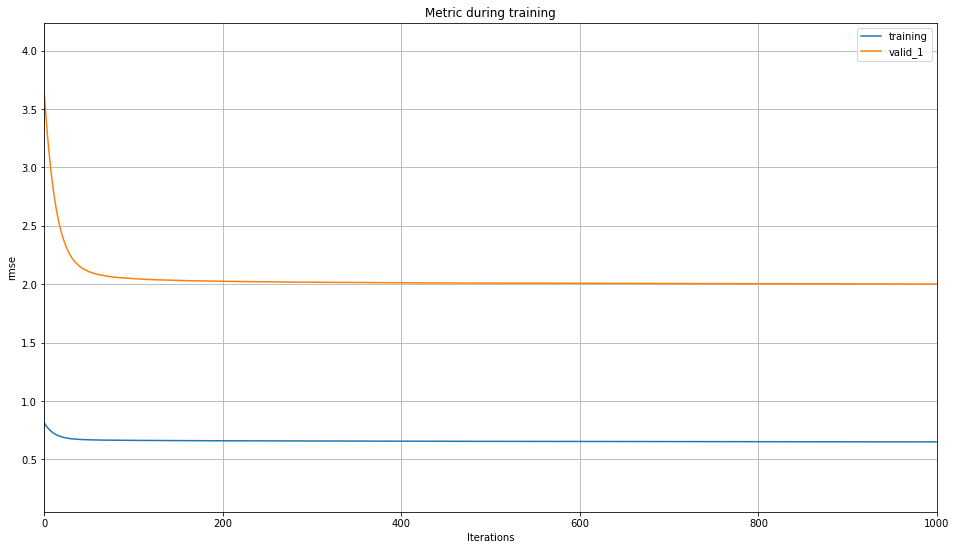

In [16]:
ax = lgb.plot_metric(model, metric="rmse", figsize=(16, 9))

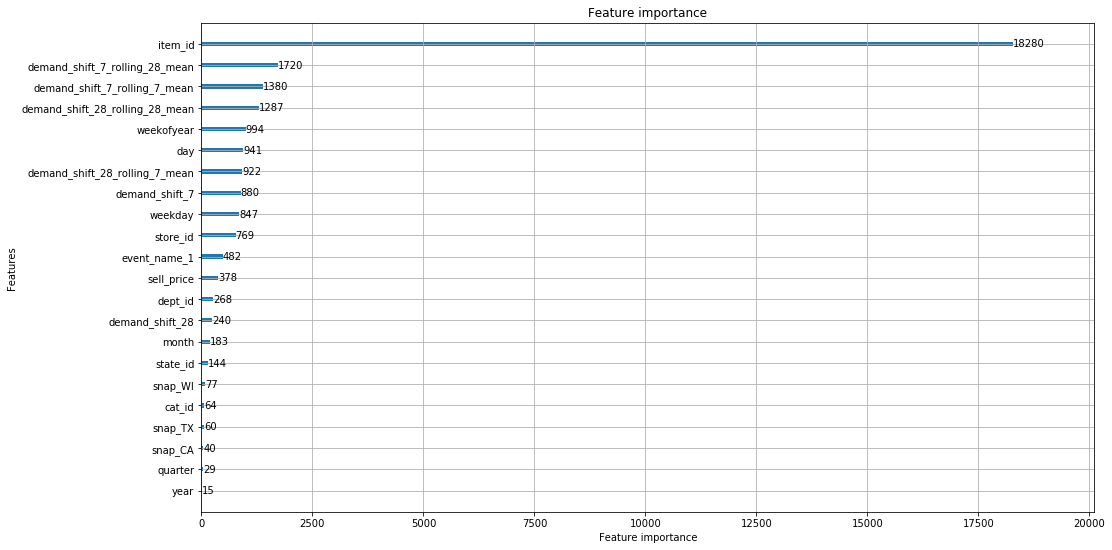

In [17]:
ax = lgb.plot_importance(model, figsize=(16, 9))

In [18]:
joblib.dump(model, model_path)

['../models/model.joblib']

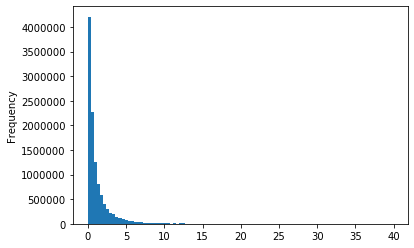

In [21]:
sample_weight.plot(kind="hist", bins=100)